# **Israel Elections Data Analysis - Lab 3**


### **environment checking**

In [1]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = True
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

Running on CoLab


### **Import modules**

In [2]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import os
import io
from matplotlib import pyplot as plt
import numpy.matlib as mtl
import copy
import random
#from scipy.stats.stats import pearsonr, spearmanr

%matplotlib inline

### **Import data**

In [3]:
# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:  # Set local path 
    data_path = "C:/Users/Daniel Ohayon/PycharmProjects/Statistics Lab"  

Mounted at /content/drive


In [4]:
# Loading elections 2020 elections data:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving votes per ballot 2020.csv to votes per ballot 2020.csv


In [5]:
import io

data_type = "ballot" # "ballot"  # city
if data_type == "ballot":
    df_2020_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_2020_raw = df_2020_raw.drop(['מעטפות חיצוניות'], axis=0)
    # preprocessing of ballot
    df_2020 = df_2020_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2020 = df_2020[df_2020.columns[9:]] # removing "metadata" columns
    
else:
    df_2020_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    # preprocessing of cities 
    df_2020 = df_2020_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2020 = df_2020[df_2020.columns[5:-1]] # removing "metadata" columns
# Dataset is now stored in a Pandas Dataframe

# **Preliminary calculations**

### **Computing votes share only for parties above a certain threshold, and extracting these parties:**

In [6]:
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par >= thresh]

top_parties = parties_votes_percents(df_2020, 0.0325)  # finding the top 8 parties

In [7]:
par_letters = top_parties.keys()

### **Creating a Dataframe for the top 8 parties:**

In [8]:
top_par_df = df_2020_raw[par_letters]                                   # dataframe for the top 8 parties

In [ ]:
top_par_df

,מחל,פה,ודעם,שס,ג,ל,אמת,טב
שם ישוב,,,,,,,,
אבו גווייעד שבט,1,6,112,2,0,0,2,0
אבו גווייעד שבט,2,0,235,0,0,0,6,0
אבו גווייעד שבט,1,2,207,0,0,1,5,0
אבו גוש,32,11,229,2,1,0,15,0
אבו גוש,23,18,330,0,0,2,6,0
...,...,...,...,...,...,...,...,...
תקוע,227,27,2,11,14,15,10,174
תקוע,188,25,0,13,8,10,7,301
תראבין אצאנע שבט,0,4,43,0,0,0,0,0


**Create a dictionary of the parties:**

In [9]:
party_names = { "מחל" : "הליכוד" , "פה" : "כחול לבן" ,"ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
               "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "ימינה"  }

# **Q1.**

In [10]:
def sample_bin(v_ij, n_ij_t):
  v_ij[v_ij > 1] = 1
  v_ij[v_ij < 0 ] = 0
  simulation = np.empty((n_ij_t.shape[0],n_ij_t.shape[1]))
  for ballot in range(n_ij_t.shape[0]):  
      for party in range(n_ij_t.shape[1]):
          simulation[ballot,party] = np.random.binomial(n_ij_t[ballot,party], v_ij[ballot,party])
  return simulation

# **Q2.**

### **:פונקציה להמרת דאטה פריים למטריצה לשם הנוחות**

In [11]:
def numpy_to_df (matrix):
  matrix = pd.DataFrame(matrix)
  matrix.index = top_par_df.index
  matrix.columns = top_par_df.columns
  return matrix

### **calculate nij tilde** 

In [12]:
# multiplying the number of voters by correct ratio
n_ij_t = copy.deepcopy(top_par_df)
fixed_ratio = (df_2020_raw["בזב"].sum())/(df_2020_raw['כשרים'].sum())
n_ij_t=round(n_ij_t.mul(fixed_ratio,axis=0))

In [13]:
n_ij_t = n_ij_t.to_numpy()   # To multiply matrices

In [14]:
n_ij_t

array([[  2.,   9., 170., ...,   0.,   3.,   0.],
       [  3.,   0., 356., ...,   0.,   9.,   0.],
       [  2.,   3., 313., ...,   2.,   8.,   0.],
       ...,
       [  0.,   6.,  65., ...,   0.,   0.,   0.],
       [ 61.,   3., 242., ...,   0.,   0.,   0.],
       [385.,  98.,   0., ...,   2.,  14., 129.]])

# **2.a**

In [15]:
vi = df_2020_raw["כשרים"]/df_2020_raw['בזב']
v_mi = np.asmatrix(vi)
vi = mtl.repmat(v_mi,8,1)
vi = vi.transpose()

# **2.b**

In [16]:
uj_percents = {"מחל" : 0.9  , "פה" : 0.8 , "ודעם" : 0.7 , "שס" : 0.6 ,
               "ג" : 0.5 , "ל" : 0.4, "אמת" : 0.3 ,  "טב" : 0.2  }

In [17]:
uj = list(uj_percents.values())
u_m= np.asmatrix(uj)
uj = mtl.repmat(u_m,10631,1)

# **2.c**

In [18]:
city_list= top_par_df.index.values.tolist()

In [19]:
rnd_vi_df = np.empty((top_par_df.shape[0],top_par_df.shape[1]))  ## dataframe for the resuls

last_city = 's'  # random letter for the firsct checking
rand_order = list(uj_percents.values())
for i in range(0, len(city_list)):
  if last_city == city_list[i]:
      rnd_vi_df[i,] = rand_order
  else: 
      random.shuffle(rand_order)
      rnd_vi_df[i,] = rand_order
      last_city = city_list[i]

# **2.1**

### **מימוש הסימולציות**

:סימולציות ללא תיקון

In [20]:
sim_a, sim_b, sim_c = [],[],[]

for i in range(50):
  sim_a.append(sample_bin(vi,n_ij_t))
  sim_b.append(sample_bin(uj,n_ij_t))
  sim_c.append(sample_bin(rnd_vi_df,n_ij_t))

:סימולציות כולל תיקון

In [21]:
votes_ratio = df_2020_raw['כשרים'].div(df_2020_raw['בזב'])

In [22]:
sim_a_fix, sim_b_fix, sim_c_fix = copy.deepcopy(sim_a), copy.deepcopy(sim_b),copy.deepcopy(sim_c),

for sim in range(50):
  for i in range(10631):
    for j in range(8):
      sim_a_fix[sim][i,j]= sim_a[sim][i,j]/votes_ratio[i]
      sim_b_fix[sim][i,j] = sim_b[sim][i,j]/votes_ratio[i]
      sim_c_fix[sim][i,j] = sim_c[sim][i,j]/votes_ratio[i]

# **2.2**

### **q**

In [23]:
n_ij_t = numpy_to_df(n_ij_t)

In [24]:
qj = parties_votes_percents(n_ij_t,0)

### **חישוב סך הבזב והכשרים**

In [25]:
df_raw_top = df_2020_raw[["בזב","כשרים","מחל","פה","ודעם","שס","ג","ל","אמת","טב"]]
sum_bzb = (df_raw_top['בזב']).sum()
sum_votes = (df_raw_top['כשרים']).sum()

### **חישוב אומדן qj**

חישוב סך הקולות בכל סימולציה

In [26]:
qj_a_hat , qj_b_hat, qj_c_hat = [],[],[]

for i in range(len(sim_a_fix)):
    qj_a_hat.append(sum(sim_a_fix[i]))
    qj_b_hat.append(sum(sim_b_fix[i]))
    qj_c_hat.append(sum(sim_c_fix[i]))

הפיכת הטבלה למטריצה לשם נוחות

In [27]:
q_a_hat , q_b_hat  , q_c_hat  = [], [], []

for sim in range(50):
  q_a_hat.append(numpy_to_df(sim_a_fix[sim]))
  q_b_hat.append(numpy_to_df(sim_b_fix[sim]))
  q_c_hat.append(numpy_to_df(sim_c_fix[sim]))  

חישוב אחוז ההצבעה לכל מפלגה בכל סימולציה

In [28]:
qj_a_fix_per , qj_b_fix_per, qj_c_fix_per = [],[],[]
for sim in range(50):
  qj_a_fix_per.append(parties_votes_percents(q_a_hat[sim],0))
  qj_b_fix_per.append(parties_votes_percents(q_b_hat[sim],0))
  qj_c_fix_per.append(parties_votes_percents(q_c_hat[sim],0))

חישוב ממוצע אחוז ההצבעה לכל מפלגה על כל הסימולציות

In [29]:
q_a_hat_mean , q_b_hat_mean , q_c_hat_mean = [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0]


# sum all the percents for each party
for par in range(8):
  for sim in range(50):
    q_a_hat_mean[par] = q_a_hat_mean[par] + qj_a_fix_per[sim][par]
    q_b_hat_mean[par] = q_b_hat_mean[par] + qj_b_fix_per[sim][par]
    q_c_hat_mean[par] = q_c_hat_mean[par] + qj_c_fix_per[sim][par]

# calculate avareage for each party
for i in range(8):
  q_a_hat_mean[i] = q_a_hat_mean[i]/50
  q_b_hat_mean[i] = q_b_hat_mean[i]/50
  q_c_hat_mean[i] = q_c_hat_mean[i]/50

:הפיכת הוקטור שמתקבל לסדרה המסומנת לפי מפלגות עבור הגרף בהמשך

In [30]:
q_a_hat_mean, q_b_hat_mean , q_c_hat_mean = pd.Series(q_a_hat_mean), pd.Series(q_b_hat_mean), pd.Series(q_c_hat_mean)
q_a_hat_mean.index,  q_b_hat_mean.index, q_c_hat_mean.index = top_par_df.columns, top_par_df.columns, top_par_df.columns

# **2.3 - חישוב התוחלת, ההטיה, השונות והשגיאה הריבועית**

פונקציה להצגת התוצאות בטבלה

In [ ]:
def table_cal (sim1, sim2, sim3):
  data_table = (pd.DataFrame([sim1, sim2, sim3])).round(3)
  data_table.columns = top_par_df.columns
  data_table.columns = data_table.columns.to_series().map(party_names)
  data_table = data_table.rename(index = {0: 'sim_a',1:'sim_b', 2:'sim_c'})
  return data_table

פונקציה להמרת דאטה פריים למטריצה

### **תוחלת**

In [ ]:
sim_a_mean = sum(qj_a_fix_per)/50
sim_b_mean = sum(qj_b_fix_per)/50
sim_c_mean = sum(qj_c_fix_per)/50

In [ ]:
mean_table = table_cal(sim_a_mean,sim_b_mean,sim_c_mean)
mean_table

,הליכוד,כחול לבן,הרשימה המשותפת,שס,יהדות התורה,ישראל ביתנו,העבודה גשר מרצ,ימינה
sim_a,0.294,0.265,0.133,0.078,0.062,0.059,0.058,0.051
sim_b,0.383,0.298,0.138,0.066,0.041,0.037,0.025,0.014
sim_c,0.303,0.239,0.145,0.082,0.067,0.060,0.058,0.046


### **שונות**

In [ ]:
sim_a_var = np.var(qj_a_fix_per,axis =0)
sim_b_var = np.var(qj_b_fix_per,axis =0)
sim_c_var = np.var(qj_c_fix_per,axis =0)

In [ ]:
sim_a_var = np.var(qj_a_fix_per, axis=0)
sim_b_var = np.var(qj_b_fix_per, axis = 0)
sim_c_var = np.var(qj_c_fix_per, axis =0)

In [ ]:
var_table = table_cal(sim_a_var,sim_b_var,sim_c_var)
var_table

 # The variance is very close to 0. About 9 digits after the dot there are numbers

,הליכוד,כחול לבן,הרשימה המשותפת,שס,יהדות התורה,ישראל ביתנו,העבודה גשר מרצ,ימינה
sim_a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sim_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sim_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **הטיה**

In [ ]:
sim_a_bias, sim_b_bias, sim_c_bias =[],[],[]

for i in range(len(qj_a_fix_per)):
    sim_a_bias.append(qj_a_fix_per[i] - qj)
    sim_b_bias.append(qj_b_fix_per[i] - qj)
    sim_c_bias.append(qj_c_fix_per[i] - qj)


In [ ]:
sim_a_bias_mean , sim_b_bias_mean , sim_c_bias_mean = [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0]


# sum all the percents for each party
for par in range(8):
  for sim in range(50):
    sim_a_bias_mean[par] = sim_a_bias_mean[par] + sim_a_bias[sim][par]
    sim_b_bias_mean[par] = sim_b_bias_mean[par] + sim_b_bias[sim][par]
    sim_c_bias_mean[par] = sim_c_bias_mean[par] + sim_c_bias[sim][par]

# calculate average for each party
for i in range(8):
  sim_a_bias_mean[i] = sim_a_bias_mean[i]/50
  sim_b_bias_mean[i] = sim_b_bias_mean[i]/50
  sim_c_bias_mean[i] = sim_c_bias_mean[i]/50

In [ ]:
bias_table = table_cal(sim_a_bias_mean,sim_b_bias_mean,sim_c_bias_mean)
bias_table

,הליכוד,כחול לבן,הרשימה המשותפת,שס,יהדות התורה,ישראל ביתנו,העבודה גשר מרצ,ימינה
sim_a,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000
sim_b,0.089,0.032,0.004,-0.012,-0.021,-0.022,-0.033,-0.037
sim_c,0.009,-0.026,0.011,0.004,0.005,0.001,0.001,-0.005


### **שגיאה ריבועית**

In [ ]:
sim_a_se , sim_b_se, sim_c_se = [],[],[]
for i in range(len(qj_a_fix_per)):
    sim_a_se.append((qj_a_fix_per[i] - qj)** 2)
    sim_b_se.append((qj_b_fix_per[i] - qj)** 2)
    sim_c_se.append((qj_c_fix_per[i] - qj)** 2)

In [ ]:
sim_a_se , sim_b_se, sim_c_se = sum(sim_a_se), sum(sim_b_se), sum(sim_c_se)

In [ ]:
se_table = table_cal(sim_a_se,sim_b_se, sim_c_se)
se_table

,הליכוד,כחול לבן,הרשימה המשותפת,שס,יהדות התורה,ישראל ביתנו,העבודה גשר מרצ,ימינה
sim_a,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
sim_b,0.394,0.053,0.001,0.008,0.022,0.025,0.054,0.068
sim_c,0.004,0.033,0.007,0.001,0.001,0.000,0.000,0.001


בסעיף זה התבקשנו לחשב תוחלת שונות והטייה, בסימולציה א התוחלת הייתה הגבוהה ביותר וההטייה הנמוכה ביותר. 
סכ"ה על פי השגיאה הריבועית ניתן לומר כי סימולציה א הכי קרובה לתוצאה אמיתית וסימולציה ב הכי רחוקה מהתוצאה האמיתית.

# **2.4 - Barplots**

### **p**

In [31]:
#עבור כל סימולציה בנפרד
p_a , p_b , p_c = [], [], []

for sim in range(50):
  p_a.append(numpy_to_df(sim_a[sim]))
  p_b.append(numpy_to_df(sim_b[sim]))
  p_c.append(numpy_to_df(sim_c[sim]))  

In [32]:
p_a_vec , p_b_vec, p_c_vec = [],[],[]
for sim in range(50):
  p_a_vec.append(parties_votes_percents(p_a[sim],-1))
  p_b_vec.append(parties_votes_percents(p_b[sim],-1))
  p_c_vec.append(parties_votes_percents(p_c[sim],-1))

In [33]:
p_a , p_b , p_c = [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0]
for i in range(8):
  for j in range(50):
    p_a[i] = p_a[i] + p_a_vec[j][i]
    p_b[i] = p_b[i] + p_b_vec[j][i]
    p_c[i] = p_c[i] + p_c_vec[j][i]

In [34]:
for i in range(8):
  p_a[i] = p_a[i]/50
  p_b[i] = p_b[i]/50
  p_c[i] = p_c[i]/50

In [35]:
p_a, p_b , p_c = pd.Series(p_a), pd.Series(p_b), pd.Series(p_c)
p_a.index,  p_b.index, p_c.index = top_par_df.columns, top_par_df.columns, top_par_df.columns

### **Barplots**

In [63]:
def parties_bar(city1, city2, city3,sd2,sd3):
    width = 0.15  # set column width
    n = 8  # number of parties
    names = party_names.values()
    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots(figsize=(8, 5))  # plt.subplots()

    city1_bar = ax.bar(np.arange(n)+width, list(city1), width, color='blue')
    city2_bar = ax.bar(np.arange(n), list(city2), width, color='lightsteelblue', yerr =sd2, capsize =5)
    city3_bar = ax.bar(np.arange(n)-width, list(city3), width, color='deepskyblue', yerr =sd3, capsize =5)

    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percent per party 2020 - vij=random uj')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    ax.legend((city1_bar[0], city2_bar[0],city3_bar[0]), ('Reality Percents','Unfixed simulation percents','Fixed simulation percents - LAB 3'))
    plt.show()

    return fig, ax

**סימולציה א**

In [45]:
sd_a = np.std(p_a_vec,axis =0)
sd_a_fix = np.std(qj_a_fix_per,axis =0)

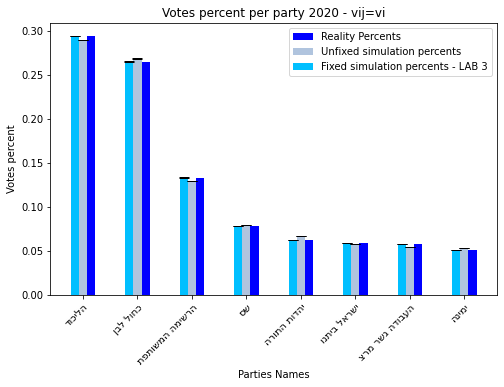

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7eb881de80>)

In [59]:
parties_bar(qj, p_a, q_a_hat_mean, sd_a,sd_a_fix)

בסימולציה זו ניתן לראות הבדלים מזעריים באחוזים. כך שאין הבדל משמעותי שניתן לתת לו דגש.

**סימולציה ב**

In [43]:
sd_b = np.std(p_b_vec,axis =0)
sd_b_fix = np.std(qj_b_fix_per,axis =0)

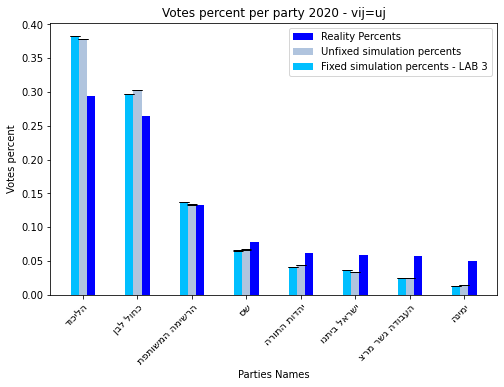

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7eb86e09b0>)

In [62]:
parties_bar(qj,p_b,q_b_hat_mean,sd_b,sd_b_fix)

**סימולציה ג**

In [52]:
sd_c = np.std(p_c_vec,axis =0)
sd_c_fix = np.std(qj_c_fix_per,axis =0)

ניתן לראות כי בסימולציה זו היה שיפור באחוזי המפלגות הגדולות שבא על חשבון המפלגות הקטנות. לדוגמא- כחול לבן גדול על חשבון ימינה

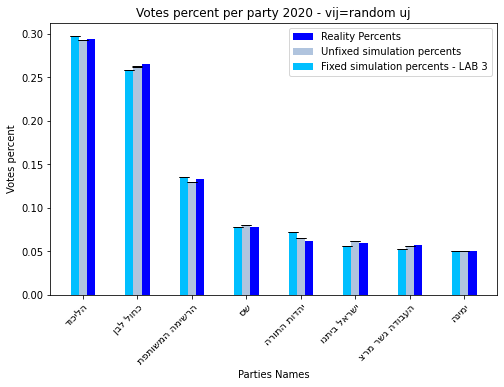

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7eb85bfa90>)

In [64]:
parties_bar(qj,p_c,q_c_hat_mean,sd_c,sd_c_fix)

בסימולציה זו בשונה מהקודמת כעת השינוי העיקרי והשיפור באחוזים הוא במפלגות קצה במפה הפוליטית, למשל הרשימה המשותפת ויהדות התורה, וירידה באחוזים במפלגות כמו כחול לבן והליכוד. אך בסכה אלו לא שינויים גדולים.